# COVID-19 ARTICLE ANALYSIS
## LDA를 통한 캐나다 코로나 토픽 변화 분석

In [361]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [573]:
#오류 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

In [362]:
#한글 깨짐 현상 방지
plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [363]:
#데이터 로드
covid = pd.read_csv('cbc-news-coronavirus-articles-march-26/news.csv') 
covid_canada = pd.read_csv('covid19_canada.csv')

In [364]:
covid.head()

,Unnamed: 0,authors,title,publish_date,description,text,url
0,0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...
1,1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...
2,2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...
3,3,['Cbc News'],Coronavirus: The latest in drug treatment and ...,2020-03-27 00:36:00,Scientists around the world are racing to find...,Scientists around the world are racing to find...,https://www.cbc.ca/news/health/coronavirus-tre...
4,4,['Cbc News'],The latest on the coronavirus outbreak for Mar...,2020-03-26 20:57:00,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,https://www.cbc.ca/news/the-latest-on-the-coro...


In [365]:
covid_canada.head()

,pruid,prname,prnameFR,date,numconf,numprob,numdeaths,numtotal,numtested,numrecover,percentrecover,ratetested,numtoday,percentoday
0,1,Canada,Canada,31-01-2020,4,0,0,4,NaN,NaN,NaN,NaN,4,4.000
1,1,Canada,Canada,08-02-2020,7,0,0,7,NaN,NaN,NaN,NaN,3,0.750
2,1,Canada,Canada,16-02-2020,8,0,0,8,NaN,NaN,NaN,NaN,1,0.143
3,1,Canada,Canada,21-02-2020,9,0,0,9,NaN,NaN,NaN,NaN,1,0.125
4,1,Canada,Canada,24-02-2020,10,0,0,10,NaN,NaN,NaN,NaN,1,0.111


# 1. 데이터 설명

## 1-1. COVID
1. authors : article authors 
2. title : news title
3. publish_date : date published
4. description : short description of the story
5. text : main story
6. url : story url

The dataset comes from CBC news's own search result regarding coronavirus.  
This dataset is intended to mobilize researchers to apply recent advances in natural language processing to generate new insights in support of the fight against this infectious disease and future pandemics.  

[출처] : [Kaggle](https://www.kaggle.com/ryanxjhan/cbc-news-coronavirus-articles-march-26/data)

## 1-2. COVID-CANADA
2020년 1월 31일 첫 확진자부터 2020년 5월 8일, 분석을 실시하는 날까지의 데이터로 캐나다의 코로나 일일확진자수, 누적확진자수, 사망자수 등이 일별로 기록되어 있음.

[출처] : [Government of Canada](https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html)

<br>
<br>
    
        
        


# 2. 데이터 전처리



## 2-1. COVID :: 시간을 제외한 날짜 데이터 생성
publish_date 변수를 년/월/일 까지만으로 분류하여 새로운 feature를 생성. (publish_date_ymd)

In [368]:
covid["publish_date_ymd"] = covid["publish_date"].apply(lambda x: x[0:10])

In [369]:
covid["publish_date_ymd"]

0       2020-03-27
1       2020-03-27
2       2020-03-26
3       2020-03-27
4       2020-03-26
           ...    
3561    2015-12-23
3562    2014-01-28
3563    2012-11-02
3564    2014-04-29
3565    2013-06-04
Name: publish_date_ymd, Length: 3566, dtype: object

## 2-2. COVID :: 날짜를 이용해 코로나 종류 별 데이터로 분리
사스, 메르스, 신종코로나 바이러스-19 세 가지로 분리  
편의를 위해 아까와 같이 날짜 데이터를 이용하되, 이번엔 ymd가 아니라 year만 이용

In [423]:
covid["publish_date_yyyy"] = covid["publish_date"].apply(lambda x: x[0:4])
covid["publish_date_yyyy"].value_counts().sort_index()

2004       2
2006       1
2012       5
2013      16
2014       6
2015       1
2019       1
2020    3534
Name: publish_date_yyyy, dtype: int64

2004\~2006년 사이의 기사는 사스 코로나 바이러스(3건),   
2012\~2015년 사이의 기사는 메르스 코로나 바이러스(28건),  
2019\~2020년 사이의 기사는 신종 코로나 바이러스-19에 대한 것으로 나눌 수 있었다.
  
### 본 연구는 신종 코로나 바이러스에 대해서만 연구하므로 COVID-19 데이터만 분리

In [424]:
covid19 = covid.query("publish_date_yyyy == '2019' or publish_date_yyyy == '2020'")
covid19

,Unnamed: 0,authors,title,publish_date,description,text,url,publish_date_ymd,publish_date_yyyy
0,0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...,2020-03-27,2020
1,1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...,2020-03-27,2020
2,2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...,2020-03-26,2020
3,3,['Cbc News'],Coronavirus: The latest in drug treatment and ...,2020-03-27 00:36:00,Scientists around the world are racing to find...,Scientists around the world are racing to find...,https://www.cbc.ca/news/health/coronavirus-tre...,2020-03-27,2020
4,4,['Cbc News'],The latest on the coronavirus outbreak for Mar...,2020-03-26 20:57:00,The latest on the coronavirus outbreak from CB...,Trudeau says rules of Quarantine Act will ...,https://www.cbc.ca/news/the-latest-on-the-coro...,2020-03-26,2020
...,...,...,...,...,...,...,...,...,...
3548,4589,['Cbc News'],Get informed on the top stories of the day in ...,2020-02-21 12:00:00,"In today's Morning Brief, we look at the outlo...",Good morning! This is our daily news roundup w...,https://www.cbc.ca/news/morning-brief-february...,2020-02-21,2020
3550,4592,['Wyatt James Schierman Is A Freelance Writer ...,Let's stop fixating on soft 'news' and pay att...,2020-02-02 09:00:00,Some of the 'big' Canadian stories of 2020 so ...,This column is an opinion by Wyatt James Schie...,https://www.cbc.ca/news/opinion/opinion-media-...,2020-02-02,2020
3552,4595,['The Associated Press'],"Fed stands pat, keeps benchmark U.S. interest ...",2020-01-29 19:14:00,The Federal Reserve kept its benchmark interes...,The Federal Reserve kept its benchmark interes...,https://www.cbc.ca/news/business/federal-reser...,2020-01-29,2020
3553,4596,"['National Affairs Editor', ""Chris Hall Is The...","It's a new year, Mr. Trudeau. What do you want...",2020-01-29 09:00:00,If there's anything to be said about the Liber...,If there's anything to be said about the Liber...,https://www.cbc.ca/news/politics/trudeau-minor...,2020-01-29,2020


## 2-3. COVID_CANADA ::  일일 확진자 및 누적확진자 컬럼만 빼고 제거

In [366]:
covid_canada = covid_canada[['date','numtotal', 'numtoday']]

In [367]:
covid_canada.head()

,date,numtotal,numtoday
0,31-01-2020,4,4
1,08-02-2020,7,3
2,16-02-2020,8,1
3,21-02-2020,9,1
4,24-02-2020,10,1


<br>
<hr>

# 3. 데이터 시각화

## 3-1. COVID :: 날짜별 코로나 뉴스 데이터 개수

In [370]:
date_count = covid['publish_date_ymd'].value_counts()
date_count = date_count.sort_index(ascending=True)

정렬결과, 데이터는 2004-01-16 ~ 2020-03-27 사이의 데이터인 것을 알 수 있었다.  
총 데이터의 개수는 3566개이다.

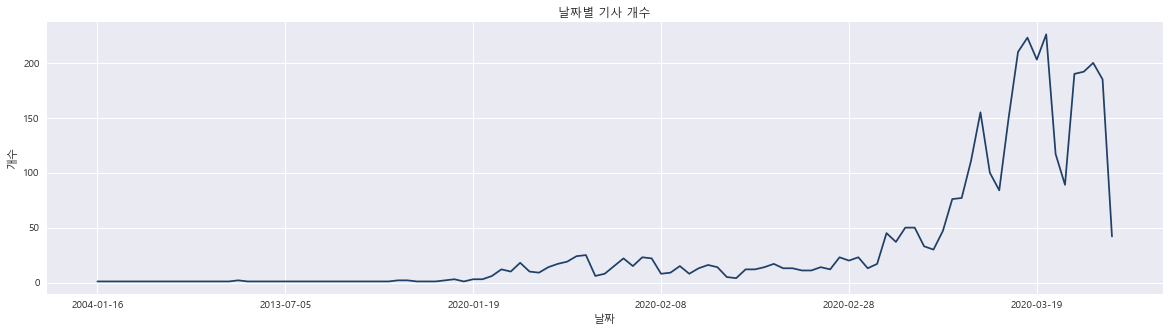

In [421]:
plt.figure(figsize=(20, 5))
date_count.plot(x=date_count.index, y=date_count.values, color="#1f4068")
plt.title("날짜별 기사 개수")
plt.xlabel("날짜")
plt.ylabel("개수")
plt.show()

날짜별로 기사를 확인한 결과 이번 신종 코로나 바이러스 데이터가 주를 이루고 있었으며  
1, 2월의 데이터보다 3월의 데이터가 월등히 많은 것을 알 수 있었다.

## 3-2. 신종 코로나 바이러스(COVID-19) 기사 개수 그래프
본 분석의 요점인 COVID19의 기사만 필터링 한 2019, 2020년의 기사 개수 추이

In [452]:
covid_count = covid19['publish_date_ymd'].value_counts()
covid_count = covid_count.sort_index(ascending=True)

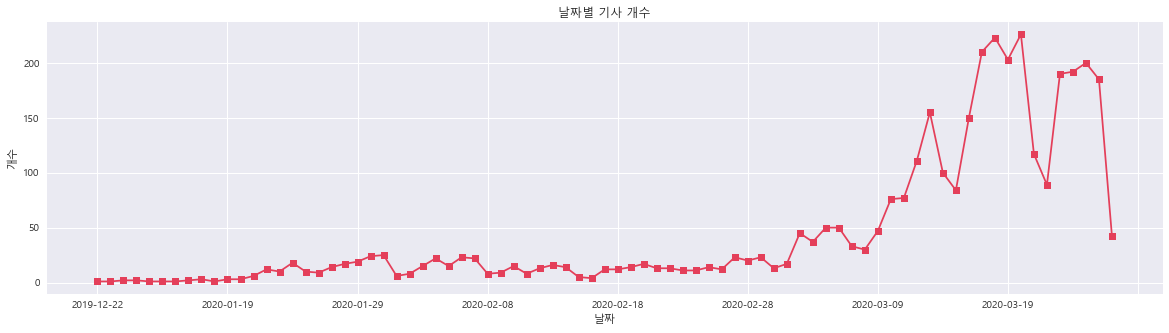

In [453]:
plt.figure(figsize=(20, 5))
covid_count.plot(x=covid_count.index, y=covid_count.values, color="#e43f5a", marker="s")
plt.title("날짜별 기사 개수")
plt.xlabel("날짜")
plt.ylabel("개수")
plt.show()

3월 17일 이후의 데이터가 많은 것으로 보아 중요한 이슈가 있었던 것으로 추측된다.

## 3-3. COVID-CANADA :: 날짜별 캐나다 누적확진자 및 일일확진자 수

In [377]:
#그래프의 가시성을 위해 알/월만 있는 변수 date_md 새로 생성
covid_canada['date_md'] = covid_canada['date'].apply(lambda x: x[0:5])
covid_canada.head()

,date,numtotal,numtoday,date_md
0,31-01-2020,4,4,31-01
1,08-02-2020,7,3,08-02
2,16-02-2020,8,1,16-02
3,21-02-2020,9,1,21-02
4,24-02-2020,10,1,24-02


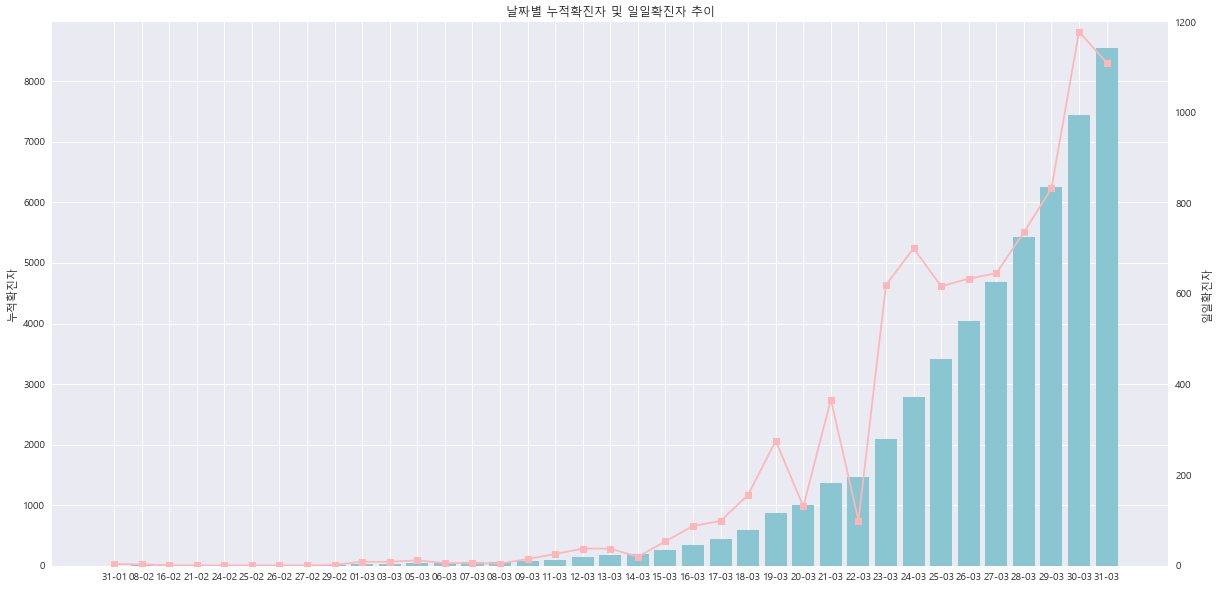

In [759]:
plt.figure(figsize=(20, 10))
plt.bar(covid_canada.date_md, covid_canada.numtotal, color="#8ac6d1")
plt.ylabel("누적확진자")
axes2 = plt.twinx()
axes2.plot(covid_canada.date_md, covid_canada.numtoday, color="#ffb6b9", marker="s")
axes2.grid(False)
axes2.set_ylabel("일일확진자")
axes2.set_xlabel("날짜(일/월)")
axes2.set_ylim(0, 1200)
plt.title("날짜별 누적확진자 및 일일확진자 추이")
plt.show()

막대그래프는 누적확진자 수 그래프이며 꺾은선 그래프는 일일 확진자 수를 나타낸다.  
거의 0에 가까운 일일확진자 수를 보이던 캐나다는 3월 중순부터 그 수간 늘어나기 시작했다.

# 3-4. Visualization 시사점

LDA를 이용한 토픽 모델링을 이용하되, 코로나 경과에 따른 변화를 분석할 것이기 때문에  
위의 캐나다 코로나 확진자 추이 데이터를 이용하여 구간을 네 부분으로 나눈다.

시기1 : 뉴스 데이터의 시작인 2019.12.22 ~ 2020.01.30 (확진자 발생 이전)   
시기2 : 01-31 ~ 03-14 최초 확진 이후 일일확진자가 50명을 넘지 않는 단계  
시기3 : 03-15 ~ 03-22 일일확진자 50명 이상 500명 이하  
시기4 : 03-23 ~ 03-27 일일확진자 500명 돌파 이후 보유한 뉴스 데이터의 끝까지  
 

### 따라서 위를 바탕으로 새로운 변수 '시기'를 만들어보자 

In [456]:
#데이터를 시간 순서로 정렬
covid19 = covid19.sort_values(by=['publish_date_ymd'])

In [457]:
#뒤죽박죽된 인덱스를 reset하여 0부터 재할당
covid19.reset_index(drop=True, inplace=True)

In [ ]:
covid19.query('publish_date_ymd == "2020-01-31"') #0~159까지 시기1
covid19.query('publish_date_ymd == "2020-03-15"') #160~1423까지 시기2
covid19.query('publish_date_ymd == "2020-03-23"') #1424~2725까지 시기3
covid19.query('publish_date_ymd == "2020-03-27"') #2726~3534까지 시기4

In [468]:
#새롭게 정의할 period 변수를 0으로 초기화 한 후에 
covid19['period'] = 0

In [481]:
#각 시기에 맞추어 값을 할당함.
covid19['period'].iloc[0:160] = 1
covid19['period'].iloc[160:1424] = 2
covid19['period'].iloc[1424:2726] = 3
covid19['period'].iloc[2726:] = 4

In [482]:
#각 시기별 기사 개수는 다음과 같음. 
covid19['period'].value_counts()

3    1302
2    1264
4     809
1     160
Name: period, dtype: int64

<br>
<br>

# 4. 워드 클라우드를 통한 단어 빈도 분석

워드 클라우드를 통해 데이터에 어떤 단어들이 많이 분포해 있는지 확인해보자

## 4-1. 워드 클라우드로 만들기 위해 string 형태로 전환

In [497]:
#필요한 패키지를 import
from wordcloud import WordCloud, ImageColorGenerator

In [498]:
#title 데이터를 리스트형태로 전환 후에 string으로 묶음.
covid19_title = ' '.join(list(covid19['title']))

In [499]:
covid19_title[:500]

"Sunday Scrum: Repatriating Canadians from China amid coronavirus outbreak South Korea reports 1st possible case of viral pneumonia Previously unknown virus may be causing pneumonia outbreak in China, WHO says Previously unknown virus may be causing pneumonia outbreak in China, WHO says Is Canada at risk from a mysterious Chinese virus related to SARS? China reports 1st death from 'new type of coronavirus' China's mystery 'coronavirus' isn't currently spreading, WHO says Woman with new coronaviru"

## 4-2. 불용어 처리

In [500]:
#필요한 패키지 임포트 및 다운로드
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\강미경\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\강미경\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\강미경\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [501]:
#이러한 것들을 불용어로 지정해놓고 있었다.
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [527]:
#분석의 용이성을 위해 다음과 같은 불용어를 추가로 제거함.
stop_words = set(stopwords.words('english'))
add_stop_words = ["'", ",", "'s", ":", ".", "?", "n't"]
for word in add_stop_words:
    stop_words.add(word)

In [528]:
#title들을 토큰화한 후에 stop word list에 있는 불용어들을 제거함.
word_tokens = word_tokenize(covid19_title)

title_list = [] #리스트 형태 하나와 
title = '' #스트링 형태 하나를 만듦.
for w in word_tokens: 
    if w not in stop_words: 
        title_list.append(w)
        title = title + ' ' + w

In [529]:
print("불용어 개수 : ", len(stop_words))
print("불용어 처리 전 : ", len(covid19_title))
print("불용어 처리 후 : ", len(title_list))
print("불용어 처리로 약 ", round(100-len(title_list)/len(covid19_title)*100, 1),"% 감소")

불용어 개수 :  186
불용어 처리 전 :  264188
불용어 처리 후 :  30374
불용어 처리로 약  88.5 % 감소


## 4-3. 마스크 이미지 업로드  및 워드클라우드 생성

In [530]:
from PIL import Image
bat = np.array(Image.open("bat.png"))

In [539]:
wc_title = WordCloud(
    background_color="white", 
    max_words=30000, #단어의 최대 빈도는 3만개로 제한
    max_font_size=300, #포함될 단어의 개수는 300개로 제한
    font_path='BMDOHYEON_ttf', 
    mask=bat).generate(title)

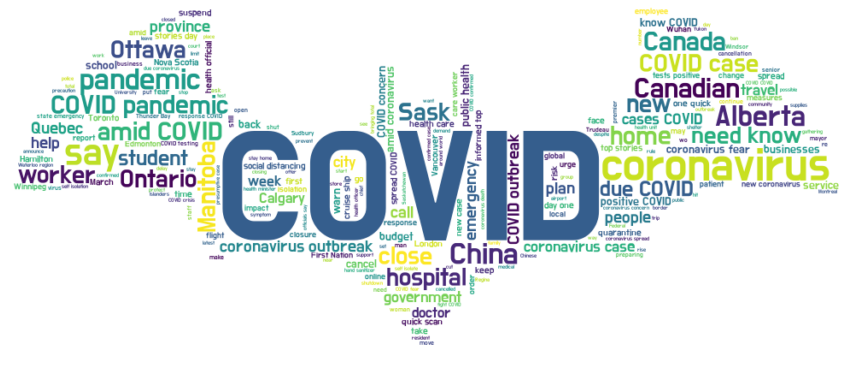

In [540]:
fig = plt.figure(figsize=(15, 15))
plt.imshow(wc_title, interpolation="bilinear")
plt.axis("off")
plt.show()

COVID가 가장 큰 부분을 차지했으며, 이외에도 코로나 바이러스와 관련된 coronavirus, pandemic 등이 눈에 띈다.  
이외에도 ontario, ottawa, alberta 등의 캐나다 주 이름의 빈도가 크게 나타나 있는데, 이로 보아 이 세 개의 주에서 코로나 이슈가 많았다고 추측해볼 수 있다.  
또 코로나 바이러스의 근원지인 China도 보이며 이외에도 close, cancle, school, worker, student와 같은 코로나로 인한 일상 생활의 변화가 암시된다.

## 4-4. TOP30 워드 추출 및 빈도 확인

In [760]:
from collections import Counter
covid_30 = sorted(Counter(title_list).items(), reverse=True, key = lambda item:item[1])
covid_30 = pd.DataFrame.from_dict(covid_30)
covid_30.columns = ['word', 'count']
covid_30[:30].to_csv("word30.csv") #해당 데이터를 csv 파일로 저장.

In [762]:
covid_30[:30]

,word,count
0,COVID-19,1523
1,coronavirus,659
2,says,250
3,cases,225
4,pandemic,223
5,amid,178
6,health,178
7,outbreak,161
8,new,161
9,B.C,159


<hr>

# 5.  LDA (Latent Dirichlet Allocation, LDA)
토픽 모델링은 문서의 집합에서 토픽을 찾아내는 프로세스를 말한다.  
이는 문서의 주제를 알아내는 일이 중요한 곳에서 사용된다.   
잠재 디리클레 할당 (Latent Dirichlet Allocation, LDA)은 토픽 모델링의 대표적인 알고리즘이다.  

코드와 방법은
[여기](https://medium.com/@omicro03/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-8%EC%9D%BC%EC%B0%A8-lda-f571b4da9d04) 를 참조하였음

## 5-1. LDA 전 간단한 전처리

In [556]:
#뒤죽박죽 섞인 인덱스를 초기화
covid19.reset_index(drop=True, inplace=True)

In [557]:
covid19

,Unnamed: 0,authors,title,publish_date,description,text,url,publish_date_ymd,publish_date_yyyy,publish_date_md,period
0,1473,['Cbc News'],Sunday Scrum: Repatriating Canadians from Chin...,2019-12-22 18:36:00,CBC News Network's Sunday Scrum panel is your ...,CBC News Network's Sunday Scrum panel is your ...,https://www.cbc.ca/news/politics/sunday-scrum-...,2019-12-22,2019,12-22,1
1,4571,['The Associated Press'],South Korea reports 1st possible case of viral...,2020-01-08 19:54:00,South Korea has put a 36-year-old Chinese woma...,South Korea has put a 36-year-old Chinese woma...,https://www.cbc.ca/news/health/south-korea-vir...,2020-01-08,2020,01-08,1
2,4387,['Thomson Reuters'],Previously unknown virus may be causing pneumo...,2020-01-09 16:27:00,A preliminary investigation has now identified...,A cluster of more than 50 pneumonia cases in C...,https://www.cbc.ca/news/health/pneumonia-china...,2020-01-09,2020,01-09,1
3,4409,['Thomson Reuters'],Previously unknown virus may be causing pneumo...,2020-01-09 16:27:00,A preliminary investigation has now identified...,A cluster of more than 50 pneumonia cases in C...,https://www.cbc.ca/news/health/pneumonia-china...,2020-01-09,2020,01-09,1
4,4567,"['Senior Writer', ""Adam Miller Is Senior Digit...",Is Canada at risk from a mysterious Chinese vi...,2020-01-11 09:00:00,Authorities are working to contain a mysteriou...,"This is an excerpt from Second Opinion, a week...",https://www.cbc.ca/news/health/china-virus-can...,2020-01-11,2020,01-11,1
...,...,...,...,...,...,...,...,...,...,...,...
3530,50,[],COVID-19 can't stop the music: Balcony boogies...,2020-03-27 05:29:00,"From trumpet-playing for dad, to a community d...","From trumpet-playing for dad, to a community d...",https://www.cbc.ca/news/canada/british-columbi...,2020-03-27,2020,03-27,4
3531,48,['Cbc News'],COVID-19 prompts acceleration of $2-million Ma...,2020-03-27 03:36:00,Main Street Project is moving fast to create s...,Main Street Project is moving fast to create s...,https://www.cbc.ca/news/canada/manitoba/msp-ex...,2020-03-27,2020,03-27,4
3532,33,['Cbc News'],Tree planting on hold in B.C.'s Interior over ...,2020-03-27 04:17:00,The plan for an ambitious reforestation season...,The plan for an ambitious reforestation season...,https://www.cbc.ca/news/canada/british-columbi...,2020-03-27,2020,03-27,4
3533,31,"['Business Reporter', 'Sophia Harris Covers Bu...","Sunwing laying off 1,500 flight staff, includi...",2020-03-27 08:00:00,When Sunwing pilot Derek Butcher recovers from...,When Sunwing pilot Derek Butcher recovers from...,https://www.cbc.ca/news/business/sunwing-layof...,2020-03-27,2020,03-27,4


In [679]:
#자주 나오는 covid, 19 등 코로나 바이러스 관련 단어를 불용어 리스트에 추가
stop_words = set(stopwords.words('english'))
add_stop_words = ["'", ",", "'s", ":", ".", "?", "n't", 'covid', '19', 'coronavirus', 'corona', 'covid-19']
for word in add_stop_words:
    stop_words.add(word)

## 5-2. 시기별로 데이터 프레임 분리

In [657]:
covid19_1 = covid19[covid19['period']==1]
covid19_2 = covid19[covid19['period']==2]
covid19_3 = covid19[covid19['period']==3]
covid19_4 = covid19[covid19['period']==4]

In [763]:
print("1시기 개수 : ", len(covid19_1))
print("2시기 개수 : ", len(covid19_2))
print("3시기 개수 : ", len(covid19_3))
print("4시기 개수 : ", len(covid19_4))
print("합계 : ", len(covid19_1)+len(covid19_2)+len(covid19_3)+len(covid19_4))

1시기 개수 :  160
2시기 개수 :  1264
3시기 개수 :  1302
4시기 개수 :  809
합계 :  3535


In [659]:
#이 또한 분리하는 과정에서 섞인 인덱스를 초기화
covid19_1.reset_index(drop=True, inplace=True)
covid19_2.reset_index(drop=True, inplace=True)
covid19_3.reset_index(drop=True, inplace=True)
covid19_4.reset_index(drop=True, inplace=True)

## 5-3. LDA에 필요한 동작들을 함수화

In [773]:
#LDA를 하기 위해 필요한 전처리들을 차례대로 진행하는 함수
from nltk.stem import WordNetLemmatizer

def preprocess(df, stop_words):
    text = df[['title']]

    #토큰화
    text['title'] = text.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)

    #불용어 처리
    text['title'] = text['title'].apply(lambda x: [word.lower() for word in x])
    text['title'] = text['title'].apply(lambda x: [word for word in x if word not in (stop_words)])

    #표제어 추출
    text['title'] = text['title'].apply(lambda x : [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])
    
    #길이가 3이하인 단어에 대해서 제거하는 작업을 수행
    tokenized_doc = text['title'].apply(lambda x : [word for word in x if len(word) > 3])
    
    #tf-idf 행렬을 만들기 위해 역토큰화
    detokenized_doc = []
    for i in range(len(text)):
        t = ' '.join(tokenized_doc[i])
        detokenized_doc.append(t)
    text['title'] = detokenized_doc
    
    return text['title']

In [774]:
#LDA를 진행하는 함수
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


def LDA(series, n_components=4, n_words=10):
    
    #LDA를 적용하기 위해 tf-idf 행렬 만들기
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(series)
    
    #토픽 모델링 - 잠재디리클레할당
    lda_model = LatentDirichletAllocation(n_components=n_components, learning_method='online', random_state=777, max_iter=1)
    lda_top = lda_model.fit_transform(X)
    
    #term : 문서 내 모든 단어의 집합.
    terms = vectorizer.get_feature_names()
    
    #모델로부터 얻은 토픽과 그 tf-idf값을 반환받음.
    topics = []
    for idx, topic in enumerate(lda_model.components_):
        print("Topic %d :" % (idx+1), [(terms[i], topic[i].round(2)) for i in topic.argsort()[:-n_words -1:-1]])
        topics.append([(terms[i]) for i in topic.argsort()[:-n_words -1:-1]])
    
    #결과물을 보기 좋게 데이터 프레임으로 출력.
    return pd.DataFrame(topics)

# 6. 분석

In [775]:
#1시기 : 1시기는 기사 개수가 몇 개 없는 이유로 토픽을 기본값인 4가 아닌 3으로 주어 출력.
covid19_1_res = LDA(preprocess(covid19_1, stop_words), 3, 10)

Topic 1 : [('officials', 3.61), ('case', 3.33), ('confirm', 2.85), ('outbreak', 2.21), ('ottawa', 2.06), ('spread', 2.02), ('ontario', 1.95), ('health', 1.75), ('year', 1.69), ('want', 1.68)]
Topic 2 : [('fear', 1.98), ('declare', 1.95), ('airlift', 1.92), ('health', 1.88), ('negotiate', 1.86), ('emergency', 1.85), ('canada', 1.83), ('rise', 1.77), ('global', 1.77), ('death', 1.68)]
Topic 3 : [('public', 2.29), ('officer', 2.23), ('chief', 2.17), ('health', 1.84), ('risk', 1.83), ('china', 1.74), ('condemn', 1.64), ('outbreak', 1.53), ('canada', 1.5), ('racist', 1.47)]


In [776]:
#2시기 
covid19_2_res = LDA(preprocess(covid19_2, stop_words))

Topic 1 : [('case', 12.48), ('cancel', 12.1), ('quarantine', 11.97), ('cruise', 10.0), ('school', 9.43), ('test', 9.26), ('close', 9.15), ('confirm', 9.0), ('ottawa', 8.99), ('ship', 8.28)]
Topic 2 : [('health', 11.53), ('case', 10.3), ('public', 8.88), ('chief', 7.49), ('manitoba', 7.24), ('fear', 6.21), ('confirm', 6.06), ('officials', 5.94), ('identify', 5.94), ('workers', 5.86)]
Topic 3 : [('need', 9.99), ('march', 8.91), ('know', 8.1), ('2020', 6.75), ('nova', 6.3), ('world', 5.99), ('scotia', 5.26), ('happen', 5.16), ('service', 5.12), ('impact', 4.72)]
Topic 4 : [('case', 11.55), ('pandemic', 10.81), ('travel', 10.56), ('quick', 9.65), ('stories', 9.63), ('inform', 9.61), ('scan', 9.6), ('prepare', 8.97), ('outbreak', 8.02), ('plan', 7.17)]


In [777]:
#3시기 
covid19_3_res = LDA(preprocess(covid19_3, stop_words))

Topic 1 : [('case', 22.2), ('march', 18.73), ('happen', 15.24), ('amid', 13.4), ('pandemic', 13.1), ('confirm', 11.77), ('need', 9.69), ('know', 8.99), ('report', 8.92), ('alberta', 8.77)]
Topic 2 : [('distance', 13.63), ('social', 13.28), ('follow', 10.77), ('face', 7.81), ('work', 7.28), ('vancouver', 6.98), ('islanders', 6.76), ('human', 6.21), ('diseases', 6.08), ('animals', 6.06)]
Topic 3 : [('spread', 13.06), ('businesses', 12.78), ('workers', 11.11), ('test', 11.05), ('veterinarians', 8.19), ('non', 8.14), ('care', 7.89), ('positive', 7.87), ('essential', 7.23), ('platforms', 7.09)]
Topic 4 : [('emergency', 13.25), ('public', 8.1), ('declare', 7.99), ('health', 7.8), ('state', 7.77), ('doctor', 7.04), ('city', 4.85), ('brace', 4.82), ('manitoba', 4.46), ('service', 4.44)]


In [778]:
#4시기 
covid19_4_res = LDA(preprocess(covid19_4, stop_words))

Topic 1 : [('hospital', 3.51), ('time', 3.44), ('start', 3.33), ('pandemic', 3.03), ('social', 3.02), ('recession', 2.89), ('demand', 2.78), ('distance', 2.54), ('canada', 2.5), ('experts', 2.38)]
Topic 2 : [('test', 7.07), ('positive', 5.58), ('city', 5.25), ('staff', 4.7), ('john', 3.77), ('isolation', 3.77), ('students', 3.41), ('project', 3.4), ('safe', 3.36), ('regina', 3.31)]
Topic 3 : [('march', 8.98), ('alberta', 8.17), ('pandemic', 7.87), ('home', 7.31), ('case', 7.16), ('need', 7.01), ('know', 6.93), ('canada', 6.84), ('service', 6.09), ('workers', 5.47)]
Topic 4 : [('emergency', 4.56), ('case', 3.7), ('state', 3.67), ('declare', 3.53), ('doctor', 3.4), ('sask', 2.88), ('drug', 2.74), ('mayor', 2.49), ('quebec', 2.42), ('border', 2.39)]


## 1시기 : 2019.12.22 ~ 2020.01.30 확진자 발생 이전


In [772]:
covid19_1_res

,0,1,2,3,4,5,6,7,8,9
0,officials,case,confirm,outbreak,ottawa,spread,ontario,health,year,want
1,fear,declare,airlift,health,negotiate,emergency,canada,rise,global,death
2,public,officer,chief,health,risk,china,condemn,outbreak,canada,racist


## 2시기 : 2020.01.31 ~ 2020.03.14 최초 확진 이후 일일확진자가 50명을 넘지 않는 단계


In [738]:
covid19_2_res

2시기 : 2020.01.31 ~ 2020.03.14 최초 확진 이후 일일확진자가 50명을 넘지 않는 단계 



,0,1,2,3,4,5,6,7,8,9
0,case,cancel,quarantine,cruise,school,test,close,confirm,ottawa,ship
1,health,case,public,chief,manitoba,fear,confirm,officials,identify,workers
2,need,march,know,2020,nova,world,scotia,happen,service,impact
3,case,pandemic,travel,quick,stories,inform,scan,prepare,outbreak,plan


## 3시기 : 2020.03.15 ~ 2020.03.22 일일확진자 50명 이상 500명 이하


In [739]:
covid19_3_res

3시기 : 2020.03.15 ~ 2020.03.22일일확진자 50명 이상 500명 이하 



,0,1,2,3,4,5,6,7,8,9
0,case,march,happen,amid,pandemic,confirm,need,know,report,alberta
1,distance,social,follow,face,work,vancouver,islanders,human,diseases,animals
2,spread,businesses,workers,test,veterinarians,non,care,positive,essential,platforms
3,emergency,public,declare,health,state,doctor,city,brace,manitoba,service


## 4시기 : 2020.03.23 ~ 2020.03.27 일일확진자 500명 돌파 이후


In [740]:
covid19_4_res

4시기 : 2020.03.23 ~ 2020.03.27 일일확진자 500명 돌파 이후 



,0,1,2,3,4,5,6,7,8,9
0,hospital,time,start,pandemic,social,recession,demand,distance,canada,experts
1,test,positive,city,staff,john,isolation,students,project,safe,regina
2,march,alberta,pandemic,home,case,need,know,canada,service,workers
3,emergency,case,state,declare,doctor,sask,drug,mayor,quebec,border


# 7. 시사점 및 연구 한계

### 시사점
1. LDA를 이용한 토픽 모델링으로 코로나 경과 별 주요 토픽이 어떻게 변하는 지 봄으로써 캐나다 여론의 흐름을 감지할 수 있었다.
2. 더불어 실제 텍스트 데이터를 이용해 분석하면서 다양한 이슈들을 경험하고 극복하였음. 

### 연구한계
1. 국가별 분석을 하고 싶었지만 캐나다 언론의 시각에서만 기술된다는 점이 한계로 다가왔음.
2. 캐나다에 대한 배경지식이 부족한 탓에 토픽 모델링 이후의 해석이 어려웠음. 